### Representation Learning on Wikipedia Categories  
#### Data Exploration Python Notebook

***

#### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import glob
import pickle

#### Importing Dataset [Wikipedia network of top categories](https://snap.stanford.edu/data/wiki-topcats.html)

In [2]:
def adjacency_list_from_edges(graph_edge_list, undirected=False):
    adj_lst = {}
    for (a,b) in graph_edge_list:
        if a not in adj_lst:
            adj_lst[a] = [b]
        else:
             adj_lst[a] += [b]
        if undirected:
            if b not in adj_lst:
                adj_lst[b] = [a]
            else:
                adj_lst[b] += [a]
    return adj_lst

In [3]:
%%time
with open('./datasets/wikipedia/wiki-topcats.txt', 'r') as f:
    wiki_edges = f.read().splitlines()
with open('./datasets/wikipedia/wiki-topcats-page-names.txt') as f:
    wiki_page_names = f.read().splitlines()
with open('./datasets/wikipedia/wiki-topcats-categories.txt') as f:
    wiki_categories = f.read().splitlines()
    
wiki_edges = [edge.split() for edge in wiki_edges]
wiki_page_names = {page.split(maxsplit=1)[0]:page.split(maxsplit=1)[1:] for page in wiki_page_names}
wiki_categories = {category.split()[0] : category.split()[1:] for category in wiki_categories}
wiki_adj_list = adjacency_list_from_edges(wiki_edges, undirected=False)
wiki_node_category = {}
for category, category_nodes in wiki_categories.items():
    for node in category_nodes:
        wiki_node_category[node] = category

CPU times: user 1min 9s, sys: 1min 56s, total: 3min 6s
Wall time: 4min 14s


In [4]:
print('|-------------------------------------|')
print('| Wikipedia network of top categories |')
print('|-------------------------------------|')
print('|     Nodes      |       {}      |'.format(len(wiki_adj_list)))
print('|-------------------------------------|')
print('|     Edges      |      {}      |'.format(len(wiki_edges)))
print('|-------------------------------------|')
print('|   Categories   |         {}      |'.format(len(wiki_categories)))
print('|-------------------------------------|')

|-------------------------------------|
| Wikipedia network of top categories |
|-------------------------------------|
|     Nodes      |       1791489      |
|-------------------------------------|
|     Edges      |      28511807      |
|-------------------------------------|
|   Categories   |         17364      |
|-------------------------------------|


#### Creating Networkx Graph Instance

In [5]:
%%time
wiki_Graph = nx.from_edgelist(wiki_edges)

CPU times: user 1min 31s, sys: 1min 45s, total: 3min 16s
Wall time: 4min 23s


In [12]:
%%time
nx.set_node_attributes(wiki_Graph, {p_no:{'Label':p_name[0] if p_name else '', 'Category': wiki_node_category[p_no]} for p_no, p_name in wiki_page_names.items()})

CPU times: user 16.6 s, sys: 2min 6s, total: 2min 22s
Wall time: 5min 53s


#### Checkpoint 1 - Saving Networkx Graph as gpickle file and other parameters as pickle file

In [14]:
%%time
nx.write_gpickle(wiki_Graph, "/Users/muditdham/Documents/checkpoints/wiki_Graph.gpickle")

CPU times: user 4min 17s, sys: 31min, total: 35min 18s
Wall time: 1h 5min 18s


In [5]:
%%time
with open('/Users/muditdham/Documents/checkpoints/wiki_edges.pickle', 'wb') as f:
    pickle.dump(wiki_edges, f)
    
with open('/Users/muditdham/Documents/checkpoints/wiki_page_names.pickle', 'wb') as f:
    pickle.dump(wiki_page_names, f)

with open('/Users/muditdham/Documents/checkpoints/wiki_categories.pickle', 'wb') as f:
    pickle.dump(wiki_categories, f)

with open('/Users/muditdham/Documents/checkpoints/wiki_adj_list.pickle', 'wb') as f:
    pickle.dump(wiki_adj_list, f)
    
with open('/Users/muditdham/Documents/checkpoints/wiki_node_category.pickle', 'wb') as f:
    pickle.dump(wiki_node_category, f)

CPU times: user 1min, sys: 1min 21s, total: 2min 21s
Wall time: 2min 57s


***

#### Loading Graph for Visualization

In [1]:
import networkx as nx
import numpy as np

In [2]:
%%time
wiki_Graph = nx.read_gpickle('/Users/muditdham/Documents/checkpoints/wiki_Graph.gpickle')

CPU times: user 1min, sys: 1min 14s, total: 2min 15s
Wall time: 3min 11s


In [13]:
node_count = 3000
# wiki_sub_graph = wiki_Graph.subgraph(['{}'.format(i) for i in np.random.choice(len(wiki_Graph.nodes), node_count)]) # random selection

wiki_sub_graph = wiki_Graph.subgraph(['{}'.format(i) for i in np.arange(node_count)]) # first node_count nodes

#### Visualizing the web (sub) graph

In [14]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, Circle, NodesOnly, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
output_notebook()

plot = figure(title="Wikipedia network of top categories", x_range=(-1.1,1.1), y_range=(-1.1,1.1), plot_width=1024, plot_height=650)
node_hover_tool = HoverTool(tooltips=[("Node", "@index"), ('Label','@Label'), ('Category','@Category')], show_arrow=False)
plot.add_tools(node_hover_tool)

graph_renderer = from_networkx(wiki_sub_graph, nx.spring_layout, scale=2)
graph_renderer.node_renderer.glyph = Circle(size=10, fill_color=Spectral4[0])
graph_renderer.node_renderer.hover_glyph = Circle(size=10, fill_color=Spectral4[2])

graph_renderer.inspection_policy = NodesOnly()

plot.renderers.append(graph_renderer)
show(plot)

Loading BokehJS ...

### Creating a subGraph of 10 Categories

In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

In [2]:
%%time
wiki_Graph = nx.read_gpickle('/Users/muditdham/Documents/checkpoints/wiki_Graph.gpickle')

CPU times: user 1min, sys: 1min 28s, total: 2min 29s
Wall time: 3min 40s


In [3]:
with open('/Users/muditdham/Documents/checkpoints/wiki_categories.pickle', 'rb') as f:
    wiki_categories = pickle.load(f)

In [4]:
%%time
subGraph_category_count = 5
wiki_categories_sorted = sorted(wiki_categories.items(), key= lambda x :len(x[1]), reverse=True)
# subGraph_categories = np.random.choice(list(wiki_categories.keys()), subGraph_category_count) # selecting randomly
subGraph_categories = [k for k,v in wiki_categories_sorted[1:6]] # selecting top categories with max size

CPU times: user 17.8 ms, sys: 2.23 ms, total: 20 ms
Wall time: 52.1 ms


In [5]:
subGraph_categories

['Category:Year_of_birth_missing_(living_people);',
 'Category:English-language_films;',
 'Category:American_films;',
 'Category:American_film_actors;',
 'Category:Main_Belt_asteroids;']

In [6]:
subGraph_nodes = set()
subGraph_node_category = {}
for category in subGraph_categories:
    for node in wiki_categories[category]:
        subGraph_nodes.add(node)
        subGraph_node_category[node] = category

In [7]:
graph_df = pd.DataFrame(subGraph_nodes, columns=['node'])
graph_df['label'] = graph_df.node.apply(lambda x: subGraph_node_category[x])
graph_df.head()

,node,label
0,706957,Category:American_film_actors;
1,1058079,Category:American_film_actors;
2,645385,Category:Year_of_birth_missing_(living_people);
3,773776,Category:English-language_films;
4,1164206,Category:American_film_actors;


In [8]:
graph_df.label.value_counts()

Category:Year_of_birth_missing_(living_people);    34005
Category:American_films;                           15302
Category:American_film_actors;                     13938
Category:Main_Belt_asteroids;                      13704
Category:English-language_films;                   12086
Name: label, dtype: int64

In [9]:
%%time
wiki_sub_graph = wiki_Graph.subgraph(subGraph_nodes)
wiki_sub_graph_largest_cc = wiki_Graph.subgraph(max(nx.connected_components(wiki_sub_graph), key=len))

CPU times: user 3.01 s, sys: 2.36 s, total: 5.38 s
Wall time: 7.56 s


In [10]:
%%time
# wiki_sub_graph_stellar = sg.StellarGraph(wiki_sub_graph)
wiki_sub_graph_stellar_largest_cc = sg.StellarGraph(wiki_sub_graph_largest_cc)

CPU times: user 11.6 s, sys: 17.7 s, total: 29.3 s
Wall time: 38.7 s


#### Modeling on subGraph 

In [11]:
import stellargraph as sg
import tensorflow as tf
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%%time
# stellar_graph = wiki_sub_graph_stellar
stellar_graph = wiki_sub_graph_stellar_largest_cc

rw = BiasedRandomWalk(stellar_graph)
walks = rw.run(nodes=list(stellar_graph.nodes()), length=50, n=30, p=0.2, q=1.0)
print('Total number of walks :: {}'.format(len(walks)))

Total number of walks :: 1649040
CPU times: user 10h 57min 17s, sys: 7min 55s, total: 11h 5min 12s
Wall time: 11h 18min 11s


In [23]:
%%time
with open('/Users/muditdham/Documents/checkpoints/walks-top-5.pickle', 'wb') as f:
    pickle.dump(walks,f)

CPU times: user 14.4 s, sys: 6.71 s, total: 21.1 s
Wall time: 29 s


In [13]:
%%time
str_walks = [[str(n) for n in walk] for walk in walks]

CPU times: user 44 s, sys: 51.5 s, total: 1min 35s
Wall time: 2min 32s


In [14]:
%%time
model = Word2Vec(str_walks, size=256, window=10, min_count=0, sg=1, workers=2, iter=1)
node_ids = model.wv.index2word  
node_embeddings = (model.wv.vectors)
node_embeddings.shape

CPU times: user 25min 35s, sys: 11.6 s, total: 25min 47s
Wall time: 14min 26s


(54968, 256)

In [15]:
%%time
transformer_tsne = TSNE(n_components=2)
node_embeddings_2d_tsne = transformer_tsne.fit_transform(node_embeddings)
node_embeddings_2d_tsne.shape

CPU times: user 1h 17min 12s, sys: 54.6 s, total: 1h 18min 6s
Wall time: 1h 4min 28s


(54968, 2)

In [16]:
%%time
transformer_pca = PCA(n_components=2)
node_embeddings_2d_pca = transformer_pca.fit_transform(node_embeddings)
node_embeddings_2d_pca.shape

CPU times: user 1.72 s, sys: 331 ms, total: 2.05 s
Wall time: 968 ms


(54968, 2)

CPU times: user 697 ms, sys: 758 ms, total: 1.45 s
Wall time: 2.54 s


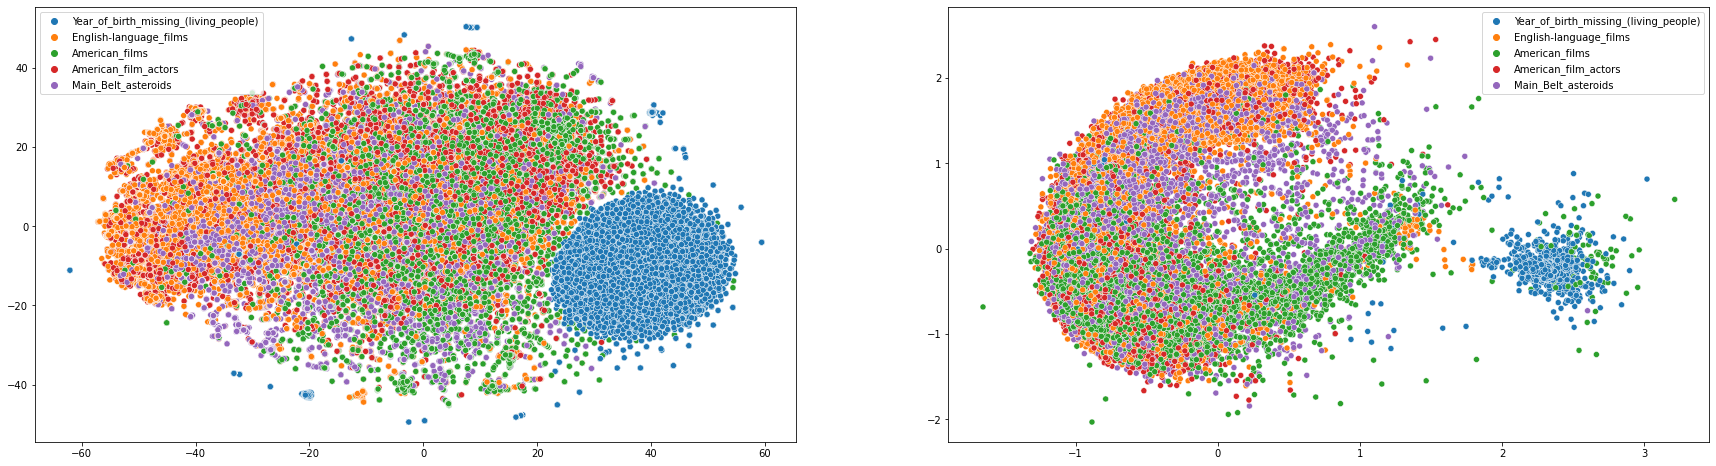

In [17]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt
custom_palette = sns.color_palette("Paired", 10)
color_dict = {cat:custom_palette[idx] for idx, cat in enumerate(subGraph_categories)}
color_nodes = [color_dict[subGraph_node_category[node]] for node in node_ids]

fig, ax = plt.subplots(1,2, figsize=(30,8))
g = sns.scatterplot(x=node_embeddings_2d_tsne[:, 0], y=node_embeddings_2d_tsne[:, 1], hue=color_nodes, ax=ax[0])
for t, l in zip(g.legend_.texts, [i.strip('Category:')[:-1] for i in subGraph_categories]): t.set_text(l)

g = sns.scatterplot(x=node_embeddings_2d_pca[:, 0], y=node_embeddings_2d_pca[:, 1], hue=color_nodes, ax=ax[1])
for t, l in zip(g.legend_.texts, [i.strip('Category:')[:-1] for i in subGraph_categories]): t.set_text(l)


In [18]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [19]:
label_dict = {i:idx for idx, i in enumerate(subGraph_categories)}
y = [label_dict[subGraph_node_category[node]] for node in node_ids]
X = node_embeddings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=24)
X_train.shape, X_test.shape

((43974, 256), (10994, 256))

In [20]:
d = X_train.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(2*d, input_shape=(d,)))
model.add(keras.layers.Dense(3*d))
model.add(keras.layers.Dense(len(label_dict), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_history = model.fit(x=X_train, y=keras.utils.to_categorical(y_train), epochs=30, validation_data=(X_test, keras.utils.to_categorical(y_test)))

Epoch 1/30
1375/1375 [==============================] - 6s 5ms/step - loss: 0.9901 - accuracy: 0.5518 - val_loss: 0.9684 - val_accuracy: 0.5655
Epoch 2/30
1375/1375 [==============================] - 7s 5ms/step - loss: 0.9637 - accuracy: 0.5646 - val_loss: 0.9684 - val_accuracy: 0.5418
Epoch 3/30
1375/1375 [==============================] - 5s 4ms/step - loss: 0.9569 - accuracy: 0.5696 - val_loss: 0.9543 - val_accuracy: 0.5619
Epoch 4/30
1375/1375 [==============================] - 6s 4ms/step - loss: 0.9548 - accuracy: 0.5696 - val_loss: 0.9688 - val_accuracy: 0.5622
Epoch 5/30
1375/1375 [==============================] - 6s 4ms/step - loss: 0.9525 - accuracy: 0.5681 - val_loss: 0.9646 - val_accuracy: 0.5639
Epoch 6/30
1375/1375 [==============================] - 6s 5ms/step - loss: 0.9512 - accuracy: 0.5692 - val_loss: 0.9583 - val_accuracy: 0.5583
Epoch 7/30
1375/1375 [==============================] - 6s 4ms/step - loss: 0.9496 - accuracy: 0.5716 - val_loss: 0.9641 - val_accuracy:

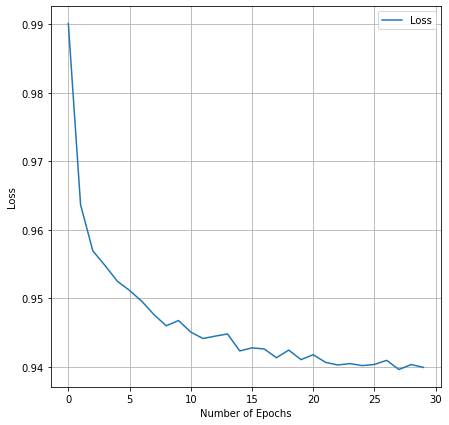

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
_ = ax.plot(model_history.epoch, model_history.history['loss'], label='Loss')
_ = ax.legend()
_ = ax.set_xlabel('Number of Epochs')
_ = ax.set_ylabel('Loss')
_ = ax.grid(True)